Model Training #2 - data ready to use in the form of numpy array from 1_tile_creation.ipynb 

In this section, we will be implementing EfficientNetB0, EfficientNetB3, EfficientNetB6 and ResNet50 architectures
to train our model and see which architecture is best suited for this application.

In [9]:
"""
MODEL TRAINING 

Andrea Perera-Ortega

"""

import os
import sys
from skimage import io
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import cohen_kappa_score
import efficientnet.tfkeras as efn
import datetime
import tensorflow as tf
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Flatten, Dense, Dropout, 
                                     Input, MaxPool2D, BatchNormalization, LeakyReLU,
                                     GlobalAveragePooling2D)
import tensorflow_addons as tfa


In [84]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# read in our data
x = np.load("/home/andrea/miccai2020/CISC881/tiles/tiles_BAL_16x64x64/tiles_BAL_3000_AUG_16x64x64.npy")
y = np.load("/home/andrea/miccai2020/CISC881/tiles/tiles_BAL_16x64x64/labels_BAL_3000_AUG_16x64x64.npy")
y = np_utils.to_categorical(y) # change to categorical labels

In [85]:
# function to standardize x values
def standardize(tiles):
    s_tiles = []
    for tile in tiles:
        tile = (tile - np.mean(tile)) / np.std(tile)
        s_tiles.append(tile)
    return np.asarray(s_tiles)

# make each tile have unit variance and zero mean,
# they've already been scaled at this point
x = standardize(x)

In [4]:
x_train, x_valtest, y_train, y_valtest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.25, stratify=y_valtest, random_state=42)

print("Splitting train/validation/test sets with 80/15/5 ratio")

# Make sure everything is the right shape
print("TRAIN")
print(x_train.shape)
print(y_train.shape)

print("VALIDATION")
print(x_val.shape)
print(y_val.shape)

print("TEST")
print(x_test.shape)
print(y_test.shape)

Splitting train/validation/test sets with 80/15/5 ratio
TRAIN
(14400, 256, 256, 3)
(14400, 6)
VALIDATION
(2700, 256, 256, 3)
(2700, 6)
TEST
(900, 256, 256, 3)
(900, 6)


In [5]:
del x # free up some memory since we don't need the original x before splitting

In [6]:
"""
Function to generate and save performance curve figures once training is complete
"""
def get_figures(history, title):
    
    # get number of epochs for plot
    epochs = len(history.history['loss'])
    print(epochs)
    n_epochs = int(epochs) + 1
    
    # TRAIN/VAL LOSS
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1,n_epochs)
    plt.plot(epochs, loss_train, 'b', label='Train loss')
    plt.plot(epochs, loss_val, 'r', label='Val loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    fig_title = title+"_Loss_2"
    plt.savefig(fig_title)
    plt.show()

    # ACCURACY 
    acc_train = history.history['categorical_accuracy']
    acc_val = history.history['val_categorical_accuracy']
    plt.plot(epochs, acc_train, 'b', label='Train cat. accuracy')
    plt.plot(epochs, acc_val, 'r', label='Val cat. accuracy')
    plt.title('Training and Validation Cat. Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Cat. Accuracy')
    plt.legend()
    fig_title = title+"_CAT_ACC_2"
    plt.savefig(fig_title)
    plt.show()

    # QWK 
    qwk_train = history.history['cohen_kappa']
    qwk_val = history.history['val_cohen_kappa']
    plt.plot(epochs, qwk_train, 'b', label='Train Cohen Kappa')
    plt.plot(epochs, qwk_val, 'r', label='Val Cohen Kappa')
    plt.title('Training and Validation QWK')
    plt.xlabel('Epochs')
    plt.ylabel('QWK')
    plt.legend()
    fig_title = title+"_QWK_2"
    plt.savefig(fig_title)
    plt.show()
    
    # AUC
    auc_train = history.history['AUC']
    auc_val = history.history['val_AUC']
    plt.plot(epochs, auc_train, 'b', label='Train AUC')
    plt.plot(epochs, auc_val, 'r', label='Val AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    fig_title = title+"_AUC_2"
    plt.savefig(fig_title)
    plt.show()


## EfficientNetB0

In [18]:
ef0_base = efn.EfficientNetB0(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False, 
    pooling='avg'
)
ef0_base = Model(inputs=ef0_base.inputs, outputs=ef0_base.layers[-2].output)
ef0_model = Sequential()
ef0_model.add(ef0_base)
ef0_model.add(GlobalAveragePooling2D())
ef0_model.add(Flatten())
ef0_model.add(BatchNormalization())
ef0_model.add(Dropout(.25))
ef0_model.add(Dense(256, activation='elu'))
ef0_model.add(BatchNormalization())
ef0_model.add(Dropout(.25))
ef0_model.add(Dense(6, activation='softmax'))

ef0_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 8, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)              

In [19]:
ef0_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.0001),
    metrics=['categorical_accuracy', tfa.metrics.CohenKappa(num_classes=6, weightage='quadratic'), 'AUC'] # tf add-on for QWK
)

In [ ]:
print("Training model on the new data for a few epochs")
epochs = 1000
batch_size = 64

# log_dir = "/home/andrea/miccai2020/CISC881/logs/fit/" + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

earlystopper = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=1,
)

lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

"""
Train the EfficientNetB0 Model.
"""
ef0_history = ef0_model.fit(
    x_train,
    y_train,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks = [earlystopper, lrreducer],
    epochs=epochs,
    verbose=1
)


900/900 [==============================] - 1s 2ms/sample - loss: 1.3529 - categorical_accuracy: 0.6122 - cohen_kappa: 0.7790 - AUC: 0.8799
34


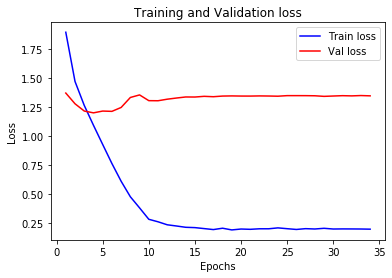

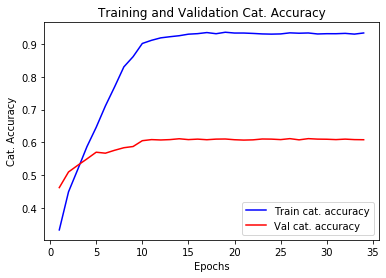

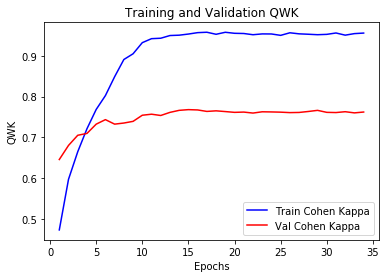

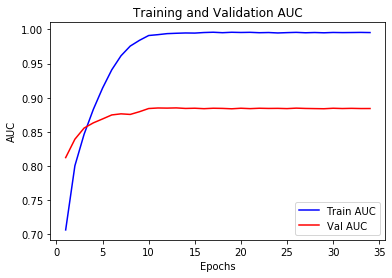

In [75]:
ef0_model.evaluate(x_test, y_test)
get_figures(ef0_history, "EFFNETB0_AUG_3000_BAL_80_15_5_SPLIT")

## EfficientNetB3

In [23]:
ef3_base = efn.EfficientNetB3(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False, 
    pooling='avg'
)
ef3_base = Model(inputs=ef3_base.inputs, outputs=ef3_base.layers[-2].output)
ef3_model = Sequential()
ef3_model.add(ef3_base)
ef3_model.add(GlobalAveragePooling2D())
ef3_model.add(Flatten())
ef3_model.add(BatchNormalization())
ef3_model.add(Dropout(.25))
ef3_model.add(Dense(256, activation='elu'))
ef3_model.add(BatchNormalization())
ef3_model.add(Dropout(.25))
ef3_model.add(Dense(6, activation='softmax'))

ef3_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 8, 8, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1536)              6144      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               393472    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)              

In [24]:
ef3_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.0001),
    metrics=['categorical_accuracy', tfa.metrics.CohenKappa(num_classes=6, weightage='quadratic'), 'AUC'] # tf add-on for QWK
)

In [26]:
# train the model on the new data for a few epochs
print("Training model on the new data for a few epochs")
epochs = 1000
batch_size = 64

# log_dir = "/home/andrea/miccai2020/CISC881/logs/fit/" + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

earlystopper = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=1,
)

lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

"""
Train the EfficientNetB3 Model.
"""
ef3_history = ef3_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks = [earlystopper, lrreducer],
    epochs=epochs,
    verbose=1
)


Training model on the new data for a few epochs
Train on 14400 samples, validate on 2700 samples
Epoch 1/1000
14400/14400 [==============================] - 164s 11ms/sample - loss: 1.9578 - categorical_accuracy: 0.3332 - cohen_kappa: 0.4395 - AUC: 0.6922 - val_loss: 1.3957 - val_categorical_accuracy: 0.4348 - val_cohen_kappa: 0.6228 - val_AUC: 0.7954
Epoch 2/1000
14400/14400 [==============================] - 155s 11ms/sample - loss: 1.5199 - categorical_accuracy: 0.4390 - cohen_kappa: 0.5838 - AUC: 0.7907 - val_loss: 1.2801 - val_categorical_accuracy: 0.5081 - val_cohen_kappa: 0.6893 - val_AUC: 0.8366
Epoch 3/1000
14400/14400 [==============================] - 156s 11ms/sample - loss: 1.3205 - categorical_accuracy: 0.5067 - cohen_kappa: 0.6454 - AUC: 0.8359 - val_loss: 1.2316 - val_categorical_accuracy: 0.5267 - val_cohen_kappa: 0.6927 - val_AUC: 0.8514
Epoch 4/1000
14400/14400 [==============================] - 150s 10ms/sample - loss: 1.1461 - categorical_accuracy: 0.5678 - cohen_k

900/900 - 3s - loss: 1.2490 - categorical_accuracy: 0.6511 - cohen_kappa: 0.7705 - AUC: 0.8965
26


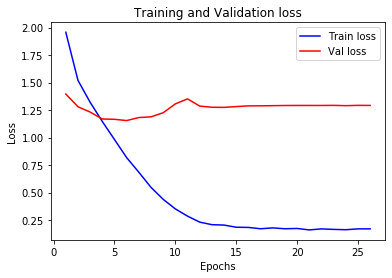

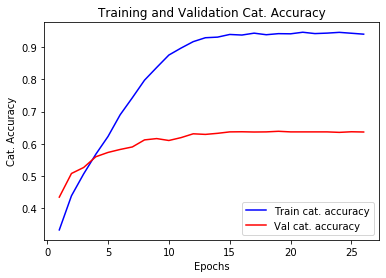

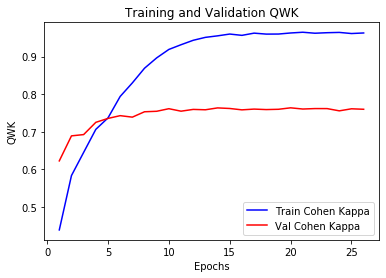

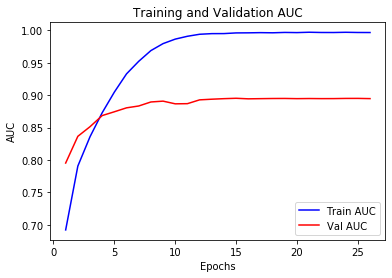

In [28]:
ef3_model.evaluate(x_test, y_test, verbose=2)
get_figures(ef3_history, "EFFNETB3_AUG_3000_BAL_80_15_5_SPLIT")

In [11]:
# model.save("/home/andrea/miccai2020/CISC881/models/EFFNETB3_AUG_3000_BAL.hdf5")

## ResNet50

In [44]:
import tensorflow as tf
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Flatten, Dense, Dropout, 
                                     Input, MaxPool2D, BatchNormalization, LeakyReLU,
                                     GlobalAveragePooling2D)
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(
    include_top = False,
    weights = "imagenet",
    input_shape = (256, 256, 3),
    classes = 6
)

resnet_model = Sequential()
resnet_model.add(resnet_base)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(6, activation="softmax"))

"""
Compile the deep model with Adam optimizer (LR=0.0001), binary cross-entropy loss,
and with binary accuracy, auc, sensitivity, and specificity metrics.
"""
resnet_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy', tfa.metrics.CohenKappa(num_classes=6, weightage='quadratic'), 'AUC'] # tf add-on for QWK
        )

# get an overall view of the layers, output shapes, and parameter counts
resnet_model.summary()



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 1542      
Total params: 24,113,798
Trainable params: 24,060,678
Non-trainable params: 53,120
____________________________________

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

# Let's train with 1000 epochs and implement early stopping
# to make sure we don't overfit. Batch size of 32 based on 
# my GPU resources and data set size
epochs = 1000
batch_size = 64

# Stop training if the validation loss doesn't decrease
# for 30 epochs
earlystopper = EarlyStopping(
    monitor='val_loss', 
    mode='auto',
    patience=20, 
    verbose=1,
)

lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

"""
Train the Resnet model. 
"""
resnet_history = resnet_model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    # class_weight=class_weights,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[earlystopper, lrreducer]
                    )


Train on 14400 samples, validate on 2700 samples
Epoch 1/1000
14400/14400 [==============================] - 75s 5ms/sample - loss: 1.6185 - categorical_accuracy: 0.3470 - cohen_kappa: 0.4982 - AUC: 0.7159 - val_loss: 2.2638 - val_categorical_accuracy: 0.1593 - val_cohen_kappa: -0.0564 - val_AUC: 0.5049
Epoch 2/1000
14400/14400 [==============================] - 71s 5ms/sample - loss: 1.3121 - categorical_accuracy: 0.4685 - cohen_kappa: 0.6640 - AUC: 0.8215 - val_loss: 1.8788 - val_categorical_accuracy: 0.1748 - val_cohen_kappa: 0.0343 - val_AUC: 0.5628
Epoch 3/1000
14400/14400 [==============================] - 71s 5ms/sample - loss: 1.0829 - categorical_accuracy: 0.5682 - cohen_kappa: 0.7655 - AUC: 0.8809 - val_loss: 2.2020 - val_categorical_accuracy: 0.2981 - val_cohen_kappa: 0.4109 - val_AUC: 0.6399
Epoch 4/1000
14400/14400 [==============================] - 71s 5ms/sample - loss: 0.8070 - categorical_accuracy: 0.6790 - cohen_kappa: 0.8517 - AUC: 0.9340 - val_loss: 2.2032 - val_cat

900/900 [==============================] - 2s 2ms/sample - loss: 2.3056 - categorical_accuracy: 0.5556 - cohen_kappa: 0.7126 - AUC: 0.8214
25


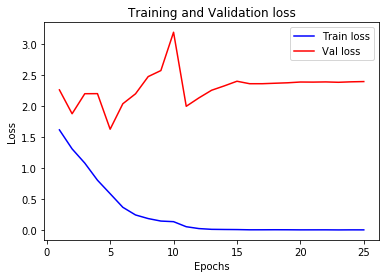

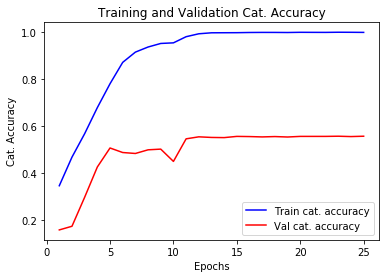

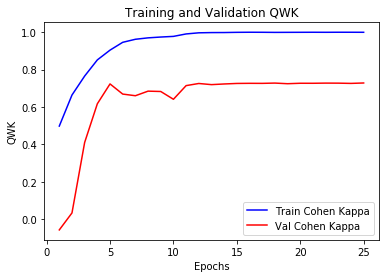

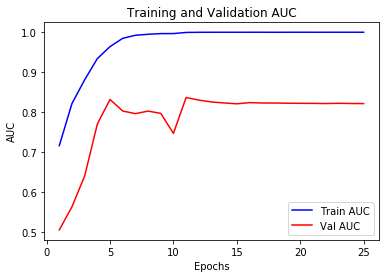

In [46]:
resnet_model.evaluate(x_test, y_test)
get_figures(resnet_history, "RESNET_AUG_3000_BAL_80_10_5_SPLIT") # change figure title based on model

## EfficientNetB6

In [34]:
"""
Let's try implementing an EfficientNetB6 Architecture
"""

ef6_base = efn.EfficientNetB6(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False, 
    pooling='avg'
)

ef6_model = Sequential()
ef6_model.add(ef6_base)
ef6_model.add(Flatten())
ef6_model.add(BatchNormalization())
ef6_model.add(Dropout(.25))
ef6_model.add(Dense(256, activation='elu'))
ef6_model.add(BatchNormalization())
ef6_model.add(Dropout(.25))
ef6_model.add(Dense(6, activation='softmax'))

ef6_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 2304)              40960136  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 2304)              9216      
_________________________________________________________________
dropout_14 (Dropout)         (None, 2304)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               590080    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)              

In [35]:
import tensorflow_addons as tfa
print('TensorFlow version:        {}'.format(tf.__version__))
print('TensorFlow-Addons version: {}'.format(tfa.__version__))


model_name = "256x256_8x_EFFICIENTNETB6_BAL_3000_AUG_75_20_5_SPLIT"

ef6_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.0001),
    metrics=['categorical_accuracy', tfa.metrics.CohenKappa(num_classes=6, weightage='quadratic'), 'AUC'] # tf add-on for QWK
)


TensorFlow version:        2.1.0
TensorFlow-Addons version: 0.9.1


In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Let's train with 1000 epochs and implement early stopping
# to make sure we don't overfit. Batch size of 32 based on 
# my GPU resources and data set size
epochs = 1000
batch_size = 32

# Stop training if the validation loss doesn't decrease
earlystopper = EarlyStopping(
    monitor='val_loss', 
    mode='auto',
    patience=20, 
    verbose=1,
)

lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

"""
Train the EfficientNetB6 model.
"""
ef6_history = ef6_model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    epochs=epochs,
                    verbose=1,
                    callbacks=[earlystopper, lrreducer]
                    )

Train on 14400 samples, validate on 2700 samples
Epoch 1/1000
14400/14400 [==============================] - 344s 24ms/sample - loss: 1.9267 - categorical_accuracy: 0.3142 - cohen_kappa: 0.4204 - AUC: 0.6775 - val_loss: 1.3759 - val_categorical_accuracy: 0.4348 - val_cohen_kappa: 0.6375 - val_AUC: 0.8016
Epoch 2/1000
14400/14400 [==============================] - 331s 23ms/sample - loss: 1.5548 - categorical_accuracy: 0.4008 - cohen_kappa: 0.5633 - AUC: 0.7670 - val_loss: 1.2846 - val_categorical_accuracy: 0.4807 - val_cohen_kappa: 0.6849 - val_AUC: 0.8331
Epoch 3/1000
14400/14400 [==============================] - 330s 23ms/sample - loss: 1.3865 - categorical_accuracy: 0.4637 - cohen_kappa: 0.6362 - AUC: 0.8139 - val_loss: 1.2202 - val_categorical_accuracy: 0.5096 - val_cohen_kappa: 0.7130 - val_AUC: 0.8522
Epoch 4/1000
14400/14400 [==============================] - 330s 23ms/sample - loss: 1.2473 - categorical_accuracy: 0.5181 - cohen_kappa: 0.6910 - AUC: 0.8478 - val_loss: 1.1940 - 

900/900 [==============================] - 4s 5ms/sample - loss: 1.3526 - categorical_accuracy: 0.6656 - cohen_kappa: 0.7739 - AUC: 0.8965
27


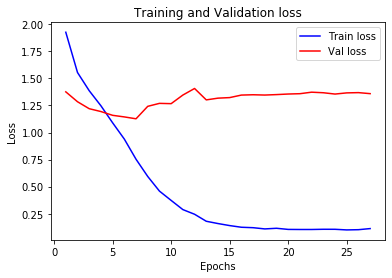

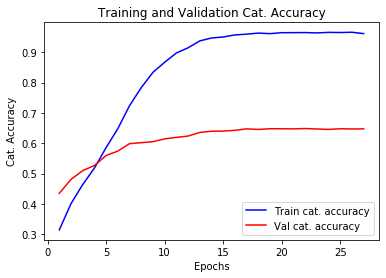

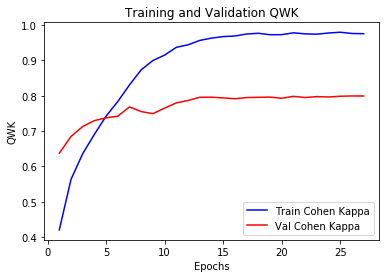

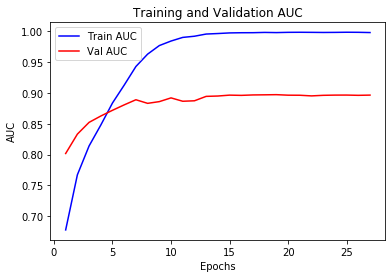

In [83]:
# generate and save performance plots, generate predictions
ef6_model.evaluate(x_test, y_test)
get_figures(ef6_history, "EFFNETB6_AUG_3000_BAL_80_10_5_SPLIT") # change figure title based on model

In [67]:
from sklearn.metrics import confusion_matrix
y_preds = ef6_model.predict(x_test)
y_test_int = np.argmax(y_test, axis=1)
y_preds_int = np.argmax(y_preds.round(), axis=1)
cm = confusion_matrix(y_test_int, y_preds_int)
print(cm)

[[120  13   3   5   5   4]
 [ 39  75  24   3   8   1]
 [ 18  21  90  16   2   3]
 [ 19   5  15  82  12  17]
 [ 13   4   6  19 100   8]
 [ 14   0   3   4   7 122]]


Confusion matrix, without normalization
[[120  13   3   5   5   4]
 [ 39  75  24   3   8   1]
 [ 18  21  90  16   2   3]
 [ 19   5  15  82  12  17]
 [ 13   4   6  19 100   8]
 [ 14   0   3   4   7 122]]


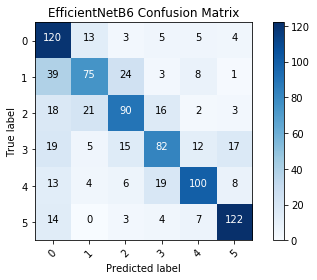

In [82]:
classes = [0,1,2,3,4,5]

# this function was used from stackoverflow to generate
# a visually appealing confusing matrix for report purposes
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("EfficientNetB6 Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
plot_confusion_matrix(cm, classes)